In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

In [2]:
#Insert the file path and load dataset

from sklearn.datasets import load_files

file_directory = r'C:/Users/polit/OneDrive/Desktop/fruits-360/Ours/Training'

def load_images(image_path):
    data = load_files(image_path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_images(file_directory)

print('Successfully loaded !')
print('Number of training images : ' , x_train.shape[0])


Successfully loaded !
Number of training images :  396


In [3]:
#Split the dataset into training and test images using a given ratio

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, stratify=y_train)

In [4]:
#Find the number of categories of fruits

from keras.utils import np_utils

num_classes = len(np.unique(y_train))

y_train = np_utils.to_categorical(y_train,num_classes)
y_test= np_utils.to_categorical(y_test,num_classes)

In [5]:
#Convert images into an array
from keras.preprocessing.image import array_to_img, img_to_array, load_img
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Shape of Training set: ',x_train.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Shape of Test set : ',x_test.shape)


Shape of Training set:  (237, 100, 100, 3)
Shape of Test set :  (159, 100, 100, 3)


In [6]:
#Scale Features

x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

In [7]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau


vgg16model = VGG16(include_top = False,weights="imagenet",input_shape = (100,100,3))
for layer in vgg16model.layers:
    layer.trainable = False

output_x = Flatten()(vgg16model.output)
output_x = Dense(num_classes, activation = "softmax")(output_x)
ourModel = Model(inputs = vgg16model.input, outputs = output_x)

ourModel.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics=["accuracy"])
print(ourModel.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)      

In [8]:
#Set the training batch size
batch_s = 20
#Set the number of epochs
nr_of_epochs = 100
#Stored weights
stored_weights = ModelCheckpoint(filepath='C:/Users/polit/OneDrive/Desktop/fruits-360/VGG16.hdf5', verbose=2,save_best_only=True)

#Prepering the train and test datasets
datagen_train = ImageDataGenerator()
datagen_train.fit(x_train)
datagen_test = ImageDataGenerator()
datagen_test.fit(x_test)

#Training the model

#Alternative run mode using test images for training validation purposes.
#history = ourModel.fit_generator(datagen_train.flow(x_train,y_train,batch_size=batch_s),steps_per_epoch=len(x_train)/batch_s, epochs = nr_of_epochs, validation_data=datagen_test.flow(x_test,y_test,batch_size=batch_s),validation_steps=len(x_test)/batch_s)

#Conditions were selected to be identical with our model to provide for a fair comparison
history = ourModel.fit(x_train,y_train,batch_s,nr_of_epochs,validation_split=0.2,callbacks=[stored_weights],verbose=2,shuffle=True)

print (history.history.keys())

print("Accuracy" + str(history.history["accuracy"]))
print("Loss" + str(history.history["loss"]))
print("Validation Loss" + str(history.history["val_loss"]))
print("Validation accuracy" + str(history.history["val_accuracy"]))

Epoch 1/100

Epoch 00001: val_loss improved from inf to 2.33149, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 7s - loss: 2.7895 - accuracy: 0.1640 - val_loss: 2.3315 - val_accuracy: 0.3125
Epoch 2/100

Epoch 00002: val_loss improved from 2.33149 to 1.55890, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 12s - loss: 1.4112 - accuracy: 0.6772 - val_loss: 1.5589 - val_accuracy: 0.5833
Epoch 3/100

Epoch 00003: val_loss improved from 1.55890 to 1.26557, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 11s - loss: 0.7952 - accuracy: 0.8730 - val_loss: 1.2656 - val_accuracy: 0.5625
Epoch 4/100

Epoch 00004: val_loss improved from 1.26557 to 1.06215, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 11s - loss: 0.4646 - accuracy: 0.9841 - val_loss: 1.0621 - val_accuracy: 0.6458
Epoch 5/100

Epoch 00005: val_loss improved from 1.06215 to 0.88746, saving model to C:/Users/pol

Epoch 39/100

Epoch 00039: val_loss improved from 0.51161 to 0.50894, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 11s - loss: 0.0116 - accuracy: 1.0000 - val_loss: 0.5089 - val_accuracy: 0.8958
Epoch 40/100

Epoch 00040: val_loss did not improve from 0.50894
10/10 - 11s - loss: 0.0109 - accuracy: 1.0000 - val_loss: 0.5134 - val_accuracy: 0.8750
Epoch 41/100

Epoch 00041: val_loss did not improve from 0.50894
10/10 - 13s - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.5129 - val_accuracy: 0.8750
Epoch 42/100

Epoch 00042: val_loss improved from 0.50894 to 0.50809, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 12s - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.5081 - val_accuracy: 0.8750
Epoch 43/100

Epoch 00043: val_loss improved from 0.50809 to 0.50215, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 12s - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.5021 - val_accuracy: 0.8958
Epoch 44/1

Epoch 83/100

Epoch 00083: val_loss improved from 0.46585 to 0.46446, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 11s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.4645 - val_accuracy: 0.8958
Epoch 84/100

Epoch 00084: val_loss did not improve from 0.46446
10/10 - 11s - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.4646 - val_accuracy: 0.8958
Epoch 85/100

Epoch 00085: val_loss did not improve from 0.46446
10/10 - 11s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4665 - val_accuracy: 0.8750
Epoch 86/100

Epoch 00086: val_loss did not improve from 0.46446
10/10 - 10s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.4648 - val_accuracy: 0.8750
Epoch 87/100

Epoch 00087: val_loss improved from 0.46446 to 0.46359, saving model to C:/Users/polit/OneDrive/Desktop/fruits-360\VGG16.hdf5
10/10 - 11s - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.4636 - val_accuracy: 0.8750
Epoch 88/100

Epoch 00088: val_loss improved from 0.46359 to 0.46306, saving model to

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
ourModel = load_model('C:/Users/polit/OneDrive/Desktop/fruits-360/VGG16.hdf5')

In [10]:
#Evaluate the model

score = ourModel.evaluate(x_test, y_test, verbose=0)
print(ourModel.metrics_names)
print(score)

['loss', 'accuracy']
[0.22760820388793945, 0.9371069073677063]


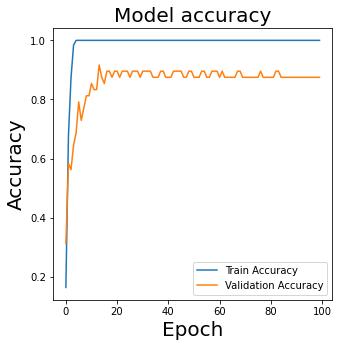

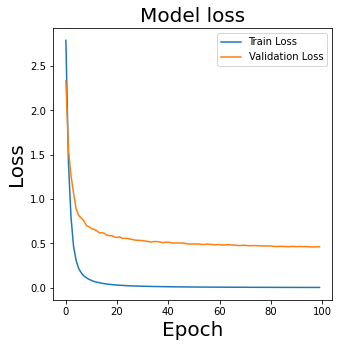

In [11]:
#Create Figure 1
fig = plt.figure(figsize=(5,5))
plt.plot(history.history["accuracy"], label = "Train Accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation Accuracy")
plt.title('Model accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.show()

#Create Figure 2
fig = plt.figure(figsize=(5,5))
plt.plot(history.history['loss'],label = "Train Loss")
plt.plot(history.history['val_loss'],label = "Validation Loss")
plt.title('Model loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.legend()
plt.show()

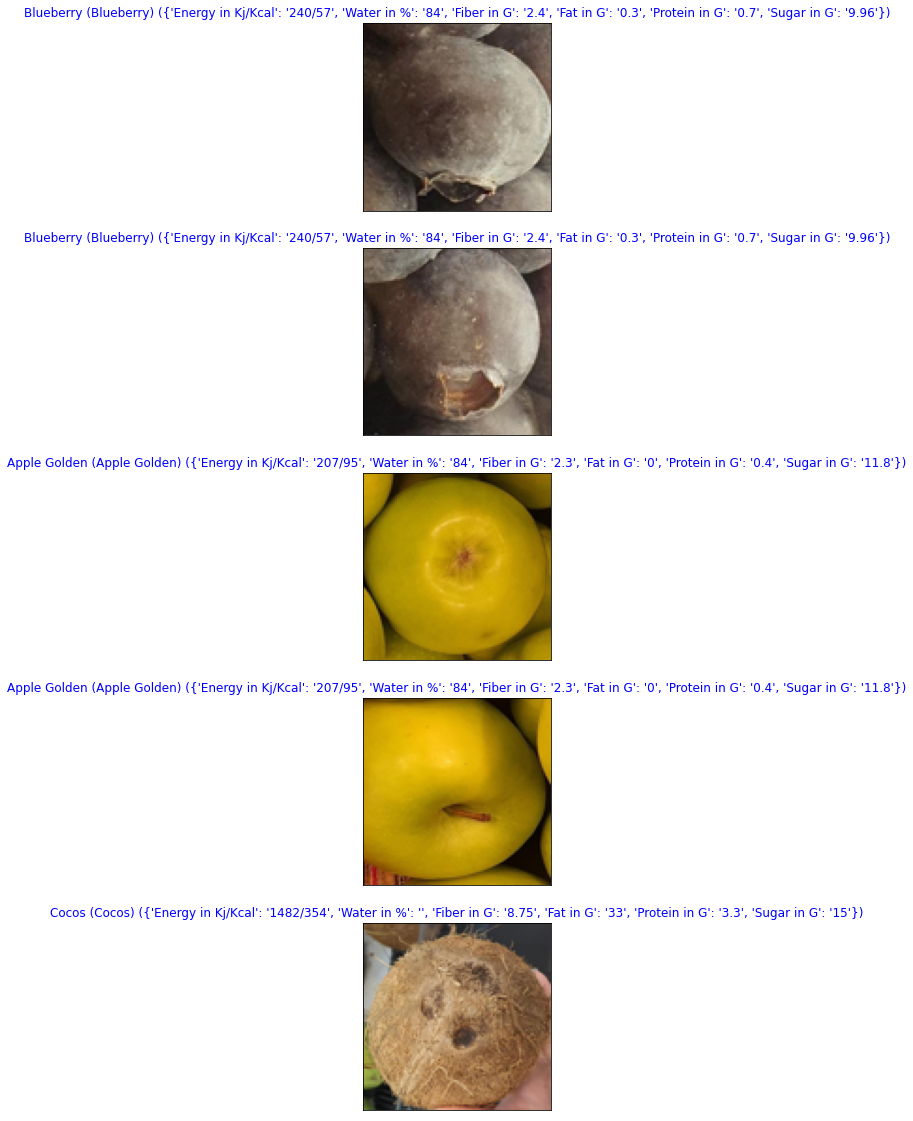

In [14]:
import csv
         
y_pred = ourModel.predict(x_test)

fig = plt.figure(figsize=(20, 20))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=5, replace=False)):
    ax = fig.add_subplot(5, 1, i + 1, xticks=[], yticks=[])

    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    
    x = target_labels[pred_idx]
    with open("nutrition.csv") as f:
        reader = csv.reader(f)
        for row in reader:
            if x in row[0]:
                nutrition_value = (row)
    val = {}
    val["Energy in Kj/Kcal"] = nutrition_value[1]
    val["Water in %"] = nutrition_value[2]
    val["Fiber in G"] = nutrition_value[3]
    val["Fat in G"] = nutrition_value[4]
    val["Protein in G"] = nutrition_value[5]
    val["Sugar in G"] = nutrition_value[6]
            
    if target_labels[pred_idx] != target_labels[true_idx]:
        val = "Prediction not correct"
    
    ax.set_title("{} ({}) ({})".format(target_labels[pred_idx], target_labels[true_idx] ,val ),
                 color=("blue" if pred_idx == true_idx else "red"))
    
    

In [15]:
import numpy as np

prob = ourModel.predict(x_test)
pred = np.argmax(prob, axis = 1)
label = np.argmax(y_test,axis = 1) 

correct_indices = np.flatnonzero(pred == label) 
incorrect_indices = np.flatnonzero(pred != label) 
print(len(correct_indices)," classified correctly") 
print(len(incorrect_indices)," classified incorrectly")


149  classified correctly
10  classified incorrectly
